In [1]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import sklearn
from matplotlib import pyplot as plt


dataset = pd.read_csv('data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
#dataset.raw_fft.iloc[0]

Populating the interactive namespace from numpy and matplotlib


# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unlabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [2]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [3]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, negative.shape

((40, 516), (1228, 516))

## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

<h2>Answer</h2>

What's missing above is that negative examples should include those that are wrong thoughts by the right person. 

However, what I am most interested in is the case where the person does not really matter - where it is really about determining the right task - universally across people. For this case, the positive and negative should be the following:

<b>First alternative:</b>

- Positive: Any person is thinking the right thing
- Negative: Any person is thinking the wrong thing

*Pros/Cons:*

- Pros: There might be some things you want to do with MindReading where more than one person should be able to trigger an action. It might also greatly enhance usability because that would mean that the person does not have to set up the device previously (person does not have to be in training set).

- Cons: That's likely not going to be very safe. I can imagine people want to be sure others cannot use their devices.

*How to test:*

- In general, you'll have to test this by marking the right thought across all people and times as right and all wrong thoughts as wrong. This dataset will serve as input to a machine learning algorithm where we train a classifier to distinguish between these two things (right & wrong thing/thought). Between False Acceptance Rate (FAR) and False Rejection Rate (FRR), we prefer a higher FRR because we don't want to trigger actions the user had no intention to trigger.

In [4]:
def right_task (task, session=0):
    return to_matrix(dataset[
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

positive = right_task('unlabeled')

In [5]:
positive.shape

(527, 516)

In [6]:
def wrong_task (task, session=0):
    return to_matrix(dataset[
        (dataset['label'] != task) &
        (dataset['session'] == session)].raw_fft)

negative = wrong_task('unlabeled')

In [7]:
negative.shape

(923, 516)

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [8]:
X = np.concatenate([positive, negative])

In [9]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [10]:
# Your code here....

def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [11]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [12]:
clf.score(X_validate, y_validate)

0.82045929018789143

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/ we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [13]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(y_pred)
    frr = false_rejects / len(y_pred)
    return far, frr

In [14]:
far, frr = far_frr(clf, X_validate, y_validate)
print('FAR: {}  FRR: {}'.format(far, frr))

FAR: 0.07515657620041753  FRR: 0.10438413361169102


In [15]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [16]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
print('FAR: {}  FRR: {}'.format(far, frr))

FAR: 0.0  FRR: 0.6525974025974026


As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

## Carinas Lab 2

<h4> My goal in this lab is to explore nonstationarity by looking at study subject A over the three sessions. </h4>

Before I even get started, I'll look into Subject A and the dataset in more detail

In [17]:
dataset.head(5)

,time,subject,session,label,raw_fft
0,2017-07-22T20:37:13.267775811Z,A,0,unlabeled,"[10.3113040924, 14.77069664, 12.213514328, 9.7..."
1,2017-07-22T20:37:14.253040444Z,A,0,unlabeled,"[11.2151269913, 14.9568557739, 10.8369417191, ..."
2,2017-07-22T20:37:15.372317746Z,A,0,unlabeled,"[6.34600162506, 12.5924711227, 10.8416910172, ..."
3,2017-07-22T20:37:16.483798739Z,A,0,unlabeled,"[10.0782966614, 16.9934558868, 18.5345039368, ..."
4,2017-07-22T20:37:17.471855277Z,A,0,unlabeled,"[4.42960739136, 9.05199050903, 4.41912555695, ..."


In [18]:
dataset.tail(5)

,time,subject,session,label,raw_fft
2775,2017-07-22T21:06:15.046552413Z,C,0,unlabeled,"[43.2245674133, 47.9200134277, 42.7252883911, ..."
2776,2017-07-22T21:06:15.54611193Z,C,0,unlabeled,"[40.0643501282, 46.0786094666, 45.231464386, 4..."
2777,2017-07-22T21:06:15.946151895Z,C,0,unlabeled,"[36.4496955872, 38.1983222961, 35.0042304993, ..."
2778,2017-07-22T21:06:16.342542608Z,C,0,unlabeled,"[34.5948257446, 38.9910774231, 47.8829689026, ..."
2779,2017-07-22T21:06:16.749482803Z,C,0,unlabeled,"[27.5732688904, 25.4237632751, 39.7749214172, ..."


In [19]:
dataset.subject.unique()

array(['A', 'B', 'C'], dtype=object)

In [20]:
len(dataset)

2780

As a first step I'll be reducing the dataset to only contain data from subject A

In [21]:
dataset = dataset[dataset.subject == 'A']

In [22]:
dataset.head()

,time,subject,session,label,raw_fft
0,2017-07-22T20:37:13.267775811Z,A,0,unlabeled,"[10.3113040924, 14.77069664, 12.213514328, 9.7..."
1,2017-07-22T20:37:14.253040444Z,A,0,unlabeled,"[11.2151269913, 14.9568557739, 10.8369417191, ..."
2,2017-07-22T20:37:15.372317746Z,A,0,unlabeled,"[6.34600162506, 12.5924711227, 10.8416910172, ..."
3,2017-07-22T20:37:16.483798739Z,A,0,unlabeled,"[10.0782966614, 16.9934558868, 18.5345039368, ..."
4,2017-07-22T20:37:17.471855277Z,A,0,unlabeled,"[4.42960739136, 9.05199050903, 4.41912555695, ..."


In [23]:
len(dataset)

1552

In [24]:
dataset.session.unique()

array([0, 1, 2])

Now we have a dataset that just contains data from subject A across 3 sessions. To make it easier for myself moving forward, I'll split that up into three different datasets to have one per session.

In [25]:
dataset0 = dataset[dataset.session == 0]
dataset1 = dataset[dataset.session == 1]
dataset2 = dataset[dataset.session == 2]

In [26]:
len0 = len(dataset0)
len1 = len(dataset1)
len2 = len(dataset2)
print (len0, len1, len2)
len0+len1+len2

222 409 921


1552

I can see that I have by far the most data in session 3 - interesting!

Now i want to check whether the same activities were conducted across all three sessions. That would be ideal!

In [27]:
dataset0.label.unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face'], dtype=object)

In [28]:
dataset1.label.unique()

array(['unlabeled', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x'], dtype=object)

In [29]:
dataset2.label.unique()

array(['unlabeled', 'calibration', 'breatheclosed', 'word_x', 'word_c',
       'phrase_x', 'phrase_c', 'face_x', 'face_c', 'breatheopen', 'song_x',
       'song_c', 'sport_x', 'sport_c'], dtype=object)

Hmm.. I want to compare patterns across sessions but I can only do that for data that is available across all three sessions. Does not seem that that's the case but I want to get the exact overview without handcounting...

In [30]:
# found online at https://stackoverflow.com/questions/2864842/common-elements-comparison-between-2-lists
def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

In [31]:
lst0 = dataset0.label.unique().tolist()
lst1 = dataset1.label.unique().tolist()
lst2 = dataset2.label.unique().tolist()

In [32]:
common_labels = common_elements(lst0,lst1)
common_labels = common_elements(common_labels,lst2)
common_labels

['unlabeled']

Oh no... it seems there is no activity that was done across all three sessions... Change of plan then. 

I'll only compare session 2 and 3 (labeled 1 and 2) because they have more activity overlap

In [33]:
common_labels = common_elements(lst1,lst2)
common_labels

['unlabeled',
 'calibration',
 'word_x',
 'phrase_x',
 'face_x',
 'breatheopen',
 'song_x',
 'sport_x']

I'll filter out the rest of the labels from the dataset to focus on just these for session 2 and 3

In [34]:
modified_dataset1 = dataset1[dataset1.label.isin(common_labels)]
modified_dataset2 = dataset2[dataset2.label.isin(common_labels)]

In [35]:
len1_m = len(modified_dataset1)
len2_m = len(modified_dataset2)
print(len1_m, len2_m)

409 638


So Dataset1 actually stays the same and Dataset2 is reduced a bit.

I'll quickly check how many readings there are per line (approximately representing a second)

In [36]:
modified_dataset1 = modified_dataset1.reset_index(drop = True)
modified_dataset2 = modified_dataset2.reset_index(drop = True)

In [37]:
print(len(modified_dataset1[0:1].raw_fft[0]))
print(len(modified_dataset2[0:1].raw_fft[0]))

516
516


In order to look at the data in terms of changes, I'm applying a fourier Transform with code from Lab1. This transforms the data to a power spectrum.

In [38]:
# Author: Nicholas Merill
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 516,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

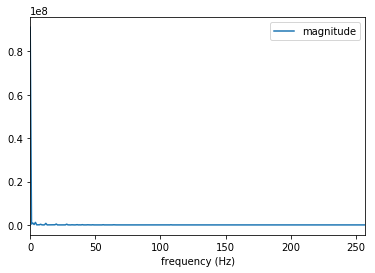

In [39]:
ps = to_power_spectrum(modified_dataset1.raw_fft[400])
ps.plot(x='frequency (Hz)')

Now I can use the bandpass function - also from lab1 - to zoom into several frequencies that might be of interest.

In [40]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

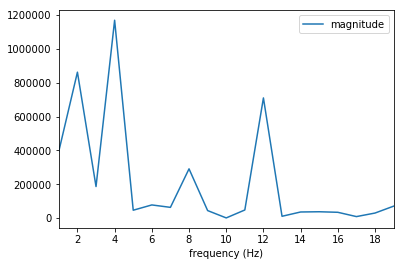

In [41]:
bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

there are two very interesting spikes at 4 and 12 Hz and another smaller one at 8 Hz. 

For comparison, we plot the bandpass in the 50 - 100 Hz range where most EMG signals will be captured

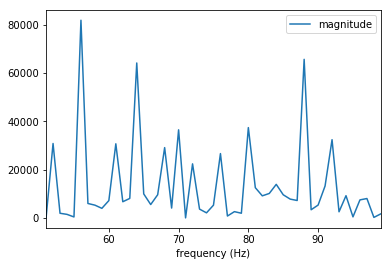

In [42]:
bandpass(ps, 50, 100).plot(x='frequency (Hz)')

In [43]:
common_labels

['unlabeled',
 'calibration',
 'word_x',
 'phrase_x',
 'face_x',
 'breatheopen',
 'song_x',
 'sport_x']

So far, so good - nothing new so far. Now - the focus is on non-stationarity. Meaning there should be a visible / measureable difference in signals for the same activity.

I'll try to pick an activity and have a look at that particular pattern across the two sessions.

In [44]:
chosen_activity = 'phrase_x' #picking phrase_x because why not; writing code so i can easily change activity
act_dataset1 = dataset1[dataset1.label == chosen_activity]
act_dataset2 = dataset2[dataset2.label == chosen_activity]
act_dataset1 = act_dataset1.reset_index(drop=True)
act_dataset2 = act_dataset2.reset_index(drop=True)


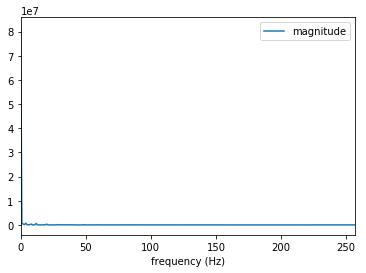

In [45]:
ps = to_power_spectrum(act_dataset1.raw_fft[17])
ps.plot(x='frequency (Hz)')

Well, that's not very insightful

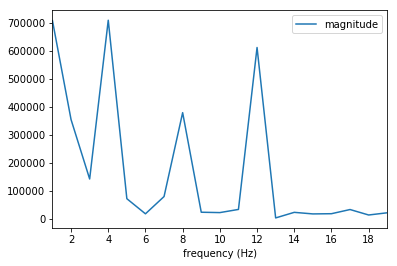

In [46]:
bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

yeah, not sure what I am looking for. Im going to jump back to time-series data

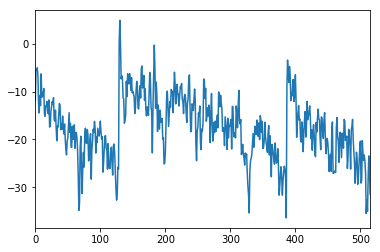

In [47]:
pd.Series(act_dataset1.raw_fft[17]).plot()

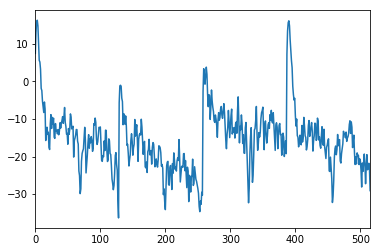

In [48]:
pd.Series(act_dataset2.raw_fft[14]).plot()

I realized I need a strategy. Since I want to quantify non-stationarity effects, I'll compare some statistics across the two sessions. I'll start with calculating the mean and see if it changes.

In [49]:
count = len(act_dataset1.raw_fft)
count # we have 24 seconds of phrase_x readings in Session 1 for person A

24

In [50]:
mean_act_d1 = []
for i in range(0,count):
    mean_act_d1.append(act_dataset1.raw_fft[i].mean()) 

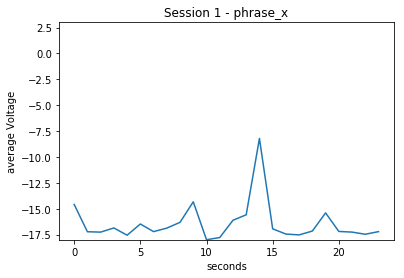

In [51]:
plt.plot(mean_act_d1)
plt.xlabel('seconds')
plt.ylabel('average Voltage')
axes = plt.gca()
axes.set_ylim([-18,3])
plt.title('Session 1 - phrase_x')
plt.show()

I'll be doing the same for Session 2 now - hoping to see some non-trivial difference

In [52]:
count2 = len(act_dataset2.raw_fft)
count2 # we have 47 seconds of phrase_x readings in Session 2 for person A

47

In [53]:
mean_act_d2 = []
for i in range(0,count2):
    mean_act_d2.append(act_dataset2.raw_fft[i].mean()) 

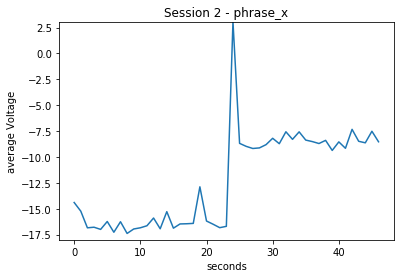

In [54]:
plt.plot(mean_act_d2)
plt.xlabel('seconds')
plt.ylabel('average Voltage')
plt.title('Session 2 - phrase_x')
axes = plt.gca()
axes.set_ylim([-18,3])
plt.show()

shrug - i was expecting a bit of difference but not this; the mean thing was probably not a good idea? Maybe I'll see something if I stitch all data together.

In [82]:
all_act_data2 = []

In [83]:
for i in range(count2):
    for item in act_dataset2[:1].raw_fft[0]:
        all_act_data2.append(item)
    

In [84]:
len(all_act_data2)

24252

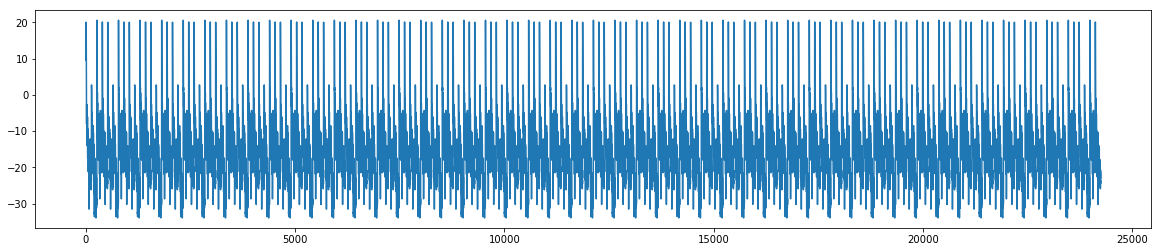

In [85]:
plt.figure(figsize=(20,4))
plt.plot(all_act_data2)


In [94]:
rolling_mean2 = pd.DataFrame(all_act_data2).rolling(center=True,window=50).mean()

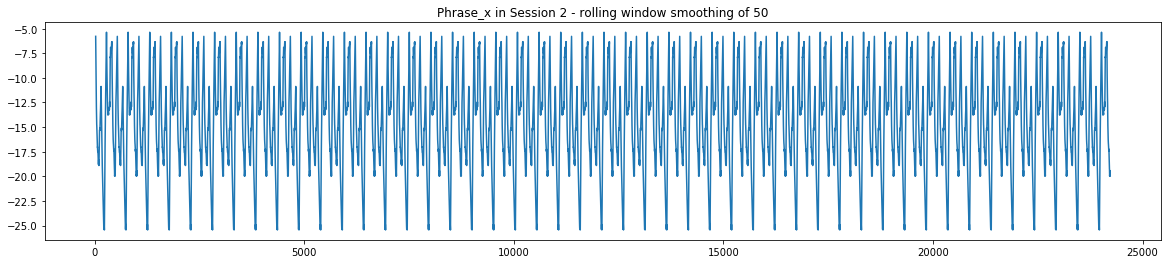

In [95]:
plt.figure(figsize=(20,4))
plt.title('Phrase_x in Session 2 - rolling window smoothing of 50')
plt.plot(rolling_mean2)

In [96]:
# funny - can't really see the spike anymore! Repeating same for Session 1

In [97]:
len(act_dataset1[:1].raw_fft[0]) * 24

12384

In [98]:
all_act_data1 = []
for i in range(len(act_dataset1)):
    for item in act_dataset1[:1].raw_fft[0]:
        all_act_data1.append(item)
    

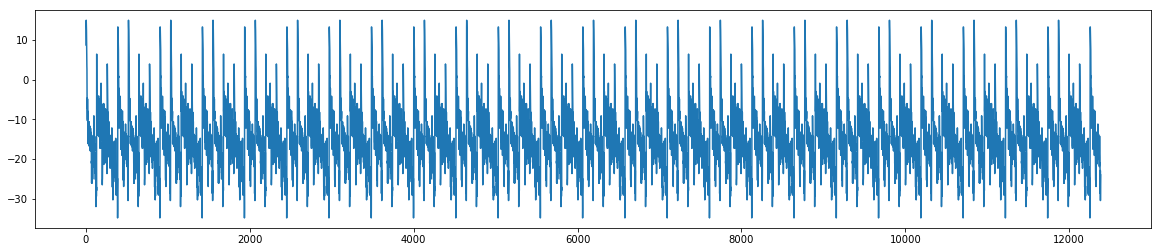

In [99]:
plt.figure(figsize=(20,4))
plt.plot(all_act_data1)


In [103]:
rolling_mean1 = pd.DataFrame(all_act_data1).rolling(center=True,window=50).mean()

0   -14.599802
dtype: float64

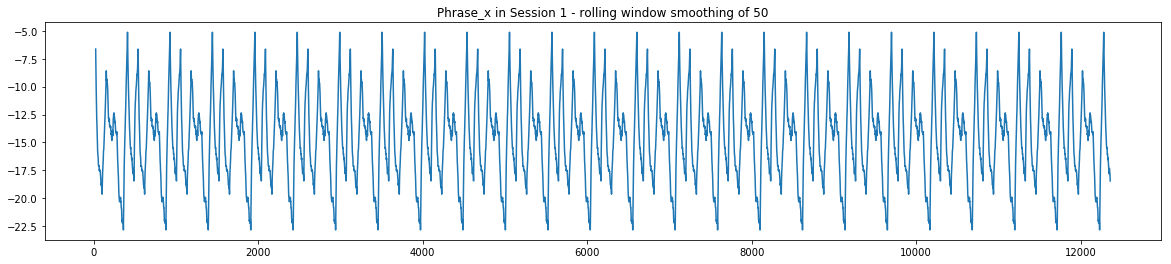

In [102]:
plt.figure(figsize=(20,4))
plt.title('Phrase_x in Session 1 - rolling window smoothing of 50')
plt.plot(rolling_mean1)

In [106]:
print(mean(all_act_data1))
print(mean(all_act_data2))

-14.584985504
-14.3980611729


In [108]:
print(np.std(all_act_data1))
print(np.std(all_act_data2))

8.26887587425
9.36952945223


there seems to be a significant difference between the signals for the two sessions although it's the same activity done by the same person - just at different occasions.